In [1]:
import os
import platform

import cffi
from PIL import Image, ImageDraw, ImageFont

In [2]:
# matplotlib&numpy are needed only for displying in jupyter.
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
ffi = cffi.FFI()
ffi.cdef("""
typedef signed char             l_int8;
typedef unsigned char           l_uint8;
typedef short                   l_int16;
typedef unsigned short          l_uint16;
typedef int                     l_int32;
typedef unsigned int            l_uint32;
typedef float                   l_float32;
typedef double                  l_float64;
typedef long long               l_int64;
typedef unsigned long long      l_uint64;
typedef int l_ok; /*!< return type 0 if OK, 1 on error */


struct Pix;
typedef struct Pix PIX;
typedef enum lept_img_format {
    IFF_UNKNOWN        = 0,
    IFF_BMP            = 1,
    IFF_JFIF_JPEG      = 2,
    IFF_PNG            = 3,
    IFF_TIFF           = 4,
    IFF_TIFF_PACKBITS  = 5,
    IFF_TIFF_RLE       = 6,
    IFF_TIFF_G3        = 7,
    IFF_TIFF_G4        = 8,
    IFF_TIFF_LZW       = 9,
    IFF_TIFF_ZIP       = 10,
    IFF_PNM            = 11,
    IFF_PS             = 12,
    IFF_GIF            = 13,
    IFF_JP2            = 14,
    IFF_WEBP           = 15,
    IFF_LPDF           = 16,
    IFF_TIFF_JPEG      = 17,
    IFF_DEFAULT        = 18,
    IFF_SPIX           = 19
};

char * getLeptonicaVersion (  );
PIX * pixRead ( const char *filename );
PIX * pixCreate ( int width, int height, int depth );
PIX * pixEndianByteSwapNew(PIX  *pixs);
l_int32 pixSetData ( PIX *pix, l_uint32 *data );
l_ok pixSetPixel ( PIX *pix, l_int32 x, l_int32 y, l_uint32 val );
l_ok pixWrite ( const char *fname, PIX *pix, l_int32 format );
l_int32 pixFindSkew ( PIX *pixs, l_float32 *pangle, l_float32 *pconf );
PIX * pixDeskew ( PIX *pixs, l_int32 redsearch );
void pixDestroy ( PIX **ppix );
l_ok pixGetResolution ( const PIX *pix, l_int32 *pxres, l_int32 *pyres );
l_ok pixSetResolution ( PIX *pix, l_int32 xres, l_int32 yres );
l_int32 pixGetWidth ( const PIX *pix );

typedef struct TessBaseAPI TessBaseAPI;
typedef struct ETEXT_DESC ETEXT_DESC;
typedef struct TessPageIterator TessPageIterator;
typedef struct TessResultIterator TessResultIterator;
typedef int BOOL;

typedef enum TessOcrEngineMode  {
    OEM_TESSERACT_ONLY          = 0,
    OEM_LSTM_ONLY               = 1,
    OEM_TESSERACT_LSTM_COMBINED = 2,
    OEM_DEFAULT                 = 3} TessOcrEngineMode;

typedef enum TessPageSegMode {
    PSM_OSD_ONLY               =  0,
    PSM_AUTO_OSD               =  1,
    PSM_AUTO_ONLY              =  2,
    PSM_AUTO                   =  3,
    PSM_SINGLE_COLUMN          =  4,
    PSM_SINGLE_BLOCK_VERT_TEXT =  5,
    PSM_SINGLE_BLOCK           =  6,
    PSM_SINGLE_LINE            =  7,
    PSM_SINGLE_WORD            =  8,
    PSM_CIRCLE_WORD            =  9,
    PSM_SINGLE_CHAR            = 10,
    PSM_SPARSE_TEXT            = 11,
    PSM_SPARSE_TEXT_OSD        = 12,
    PSM_COUNT                  = 13} TessPageSegMode;

typedef enum TessPageIteratorLevel {
     RIL_BLOCK    = 0,
     RIL_PARA     = 1,
     RIL_TEXTLINE = 2,
     RIL_WORD     = 3,
     RIL_SYMBOL    = 4} TessPageIteratorLevel;    

TessPageIterator* TessBaseAPIAnalyseLayout(TessBaseAPI* handle);
TessPageIterator* TessResultIteratorGetPageIterator(TessResultIterator* handle);

BOOL TessPageIteratorNext(TessPageIterator* handle, TessPageIteratorLevel level);
BOOL TessPageIteratorBoundingBox(const TessPageIterator* handle, TessPageIteratorLevel level,
                                 int* left, int* top, int* right, int* bottom);

const char* TessVersion();

TessBaseAPI* TessBaseAPICreate();
int    TessBaseAPIInit3(TessBaseAPI* handle, const char* datapath, const char* language);
int    TessBaseAPIInit2(TessBaseAPI* handle, const char* datapath, const char* language, TessOcrEngineMode oem);
void   TessBaseAPISetImage(TessBaseAPI* handle,
                           const unsigned char* imagedata, int width, int height,
                           int bytes_per_pixel, int bytes_per_line);
void   TessBaseAPISetImage2(TessBaseAPI* handle, struct Pix* pix);

BOOL   TessBaseAPISetVariable(TessBaseAPI* handle, const char* name, const char* value);
BOOL   TessBaseAPIDetectOrientationScript(TessBaseAPI* handle, char** best_script_name, 
                                                            int* best_orientation_deg, float* script_confidence, 
                                                            float* orientation_confidence);
int TessBaseAPIRecognize(TessBaseAPI* handle, ETEXT_DESC* monitor);
TessResultIterator* TessBaseAPIGetIterator(TessBaseAPI* handle);
BOOL   TessResultIteratorNext(TessResultIterator* handle, TessPageIteratorLevel level);
char*  TessResultIteratorGetUTF8Text(const TessResultIterator* handle, TessPageIteratorLevel level);
float  TessResultIteratorConfidence(const TessResultIterator* handle, TessPageIteratorLevel level);
char*  TessBaseAPIGetUTF8Text(TessBaseAPI* handle);
const char*  TessResultIteratorWordFontAttributes(const TessResultIterator* handle, BOOL* is_bold, BOOL* is_italic,
                                                              BOOL* is_underlined, BOOL* is_monospace, BOOL* is_serif,
                                                              BOOL* is_smallcaps, int* pointsize, int* font_id);
void   TessBaseAPIEnd(TessBaseAPI* handle);
void   TessBaseAPIDelete(TessBaseAPI* handle);
""")

In [4]:
def pil2PIX32(im, leptonica):
    """Convert PIL to leptonica PIX."""
    # At the moment we handle everything as RGBA image
    if im.mode != "RGBA":
        im = im.convert("RGBA")
    depth = 32
    width, height = im.size
    data = im.tobytes("raw", "RGBA")
    pixs = leptonica.pixCreate(width, height, depth)
    leptonica.pixSetData(pixs, ffi.from_buffer("l_uint32[]", data))

    try:
        resolutionX = im.info['resolution'][0]
        resolutionY = im.info['resolution'][1]
        leptonica.pixSetResolution(pixs, resolutionX, resolutionY)
    except KeyError:
        pass
    try:
        resolutionX = im.info['dpi'][0]
        resolutionY = im.info['dpi'][1]
        leptonica.pixSetResolution(pixs, resolutionX, resolutionY)
    except KeyError:
        pass

    return leptonica.pixEndianByteSwapNew(pixs)

In [5]:
# Setup path and library names
architecture = platform.architecture()
dll_dir = ""
if platform.architecture()[1].lower().startswith('windows'):
    dll_dir = "win"

if platform.architecture()[0] == '64bit':
    dll_dir += "64"
#     dll_dir += "64"
elif platform.architecture()[0] == '32bit':
    dll_dir += "32"

abs_path = os.path.join(os.getcwd(), dll_dir)

env_path = os.environ['PATH']
if abs_path not in env_path:
    os.environ['PATH'] = abs_path + ";" + env_path
tess_libname = os.path.join(abs_path, "tesseract41.dll")
lept_libname = os.path.join(abs_path, "leptonica-1.78.0.dll")

# Use project tessdata
tessdata = os.path.join(os.getcwd(), "tessdata")
os.environ['TESSDATA_PREFIX'] = tessdata

In [6]:
# Load libraries in ABI mode
if os.path.exists(tess_libname):
    tesseract = ffi.dlopen(tess_libname)
else:
    print(f"'{tess_libname}' does not exists!")
tesseract_version = ffi.string(tesseract.TessVersion())
print('Tesseract-ocr version', tesseract_version.decode('utf-8'))

if os.path.exists(lept_libname):
    leptonica = ffi.dlopen(lept_libname)
else:
    print(f"'{lept_libname}' does not exists!")
leptonica_version = ffi.string(leptonica.getLeptonicaVersion())
print(leptonica_version.decode('utf-8'))
api = None

Tesseract-ocr version 4.1.0-rc1-71-ge4bf
leptonica-1.78.0 (Mar  8 2019, 18:10:35) [MSC v.1915 LIB Release x64]


In [7]:
# Create tesseract API
if api:
    tesseract.TessBaseAPIEnd(api)
    tesseract.TessBaseAPIDelete(api)
api = tesseract.TessBaseAPICreate()

In [8]:
# Load image with PIL and convert it to leptonica PIX
filename = r"test.jpg"
im = Image.open(filename)
pix = pil2PIX32(im, leptonica)

# Get information about DPI
x_dpi = ffi.new('int *')
y_dpi = ffi.new('int *')
leptonica.pixGetResolution(pix, x_dpi, y_dpi)
print(f"Image {filename} has {x_dpi[0]}x{y_dpi[0]} DPI.")

Image test.jpg has 0x0 DPI.


In [9]:
# Parameters fro API initialization
# use xz compressed traineddata file - feature is available in recent github code
lang = "eng_xz"
# OEM_DEFAULT OEM_LSTM_ONLY OEM_TESSERACT_ONLY OEM_TESSERACT_LSTM_COMBINED
oem = tesseract.OEM_DEFAULT
# Initialize API, set image and regonize it
tesseract.TessBaseAPIInit3(api, tessdata.encode(), lang.encode())
tesseract.TessBaseAPISetImage2(api, pix)
tesseract.TessBaseAPIRecognize(
    api, ffi.NULL)  # recognize is needed to get result iterator

0

In [10]:
# Print whole recognized text
utf8_text = ffi.string(tesseract.TessBaseAPIGetUTF8Text(api)).decode('utf-8')
print(utf8_text)

FOCUS
LEADERS CONCENTRATE
SINGLE-MINDEDLY ON ONE
THING— THE MOST IMPORTANT
THING, AND THEY STAY AT IT
UNTIL IT’S COMPLETE.
Brian Tracy
BRIANTRACY.COM



In [11]:
# Use result iterator to get confidence and bouding box for words
idx = 0
results = []
left = ffi.new('int *')
top = ffi.new('int *')
right = ffi.new('int *')
bottom = ffi.new('int *')
level = tesseract.RIL_WORD  # RIL_SYMBOL RIL_WORD RIL_TEXTLINE RIL_PARA RIL_BLOCK

result_iterator = tesseract.TessBaseAPIGetIterator(api)
while 1:
    page_iterator = tesseract.TessResultIteratorGetPageIterator(
        result_iterator)
    tesseract.TessPageIteratorBoundingBox(page_iterator, level, left, top,
                                          right, bottom)
    text = ffi.string(
        tesseract.TessResultIteratorGetUTF8Text(result_iterator,
                                                level)).decode('utf-8')
    conf = tesseract.TessResultIteratorConfidence(result_iterator, level)
    print(
        f"""{idx} confidence: {conf} - [{left[0]}, {top[0]}, {right[0]}, {bottom[0]}]; {text}"""
    )
    idx = idx + 1
    results.append((left[0], top[0], right[0], bottom[0], text, conf))
    if not tesseract.TessResultIteratorNext(result_iterator, level):
        break

0 confidence: 96.37222290039062 - [358, 42, 443, 66]; FOCUS
1 confidence: 95.75750732421875 - [147, 263, 327, 294]; LEADERS
2 confidence: 95.39168548583984 - [341, 266, 653, 294]; CONCENTRATE
3 confidence: 91.18311309814453 - [116, 315, 506, 342]; SINGLE-MINDEDLY
4 confidence: 96.78202056884766 - [517, 314, 580, 342]; ON
5 confidence: 96.2064208984375 - [594, 314, 683, 342]; ONE
6 confidence: 56.70866394042969 - [78, 362, 238, 390]; THING—
7 confidence: 96.71342468261719 - [248, 363, 329, 390]; THE
8 confidence: 95.31755828857422 - [341, 361, 459, 390]; MOST
9 confidence: 95.31755828857422 - [471, 362, 720, 390]; IMPORTANT
10 confidence: 96.21450805664062 - [98, 410, 245, 443]; THING,
11 confidence: 96.06922149658203 - [257, 410, 350, 438]; AND
12 confidence: 93.0475845336914 - [361, 410, 472, 438]; THEY
13 confidence: 93.8777084350586 - [475, 410, 582, 439]; STAY
14 confidence: 96.31163787841797 - [593, 411, 648, 438]; AT
15 confidence: 95.3425521850586 - [661, 411, 699, 438]; IT
16 c

In [12]:
# Display Bound boxes with result text
result_img = im.convert("RGBA")
draw_font = ImageFont.truetype('arial', 18)
padding = 2
box_color = (255, 255, 255, 128)
font_color = (0, 0, 255, 255)

draw = ImageDraw.Draw(result_img)
for (startX, startY, endX, endY, text, conf) in results:
    draw.rectangle(((startX, startY), (endX, endY)), fill=box_color)
    draw.text((startX + padding, startY + padding),
              text,
              font=draw_font,
              fill=font_color)

# If you do not have/want to use matplotlib&numpy uncomment folowing line
# result_img.show()
# To save this image you can use:
# result_img.save("BoundingBox.png", "PNG")

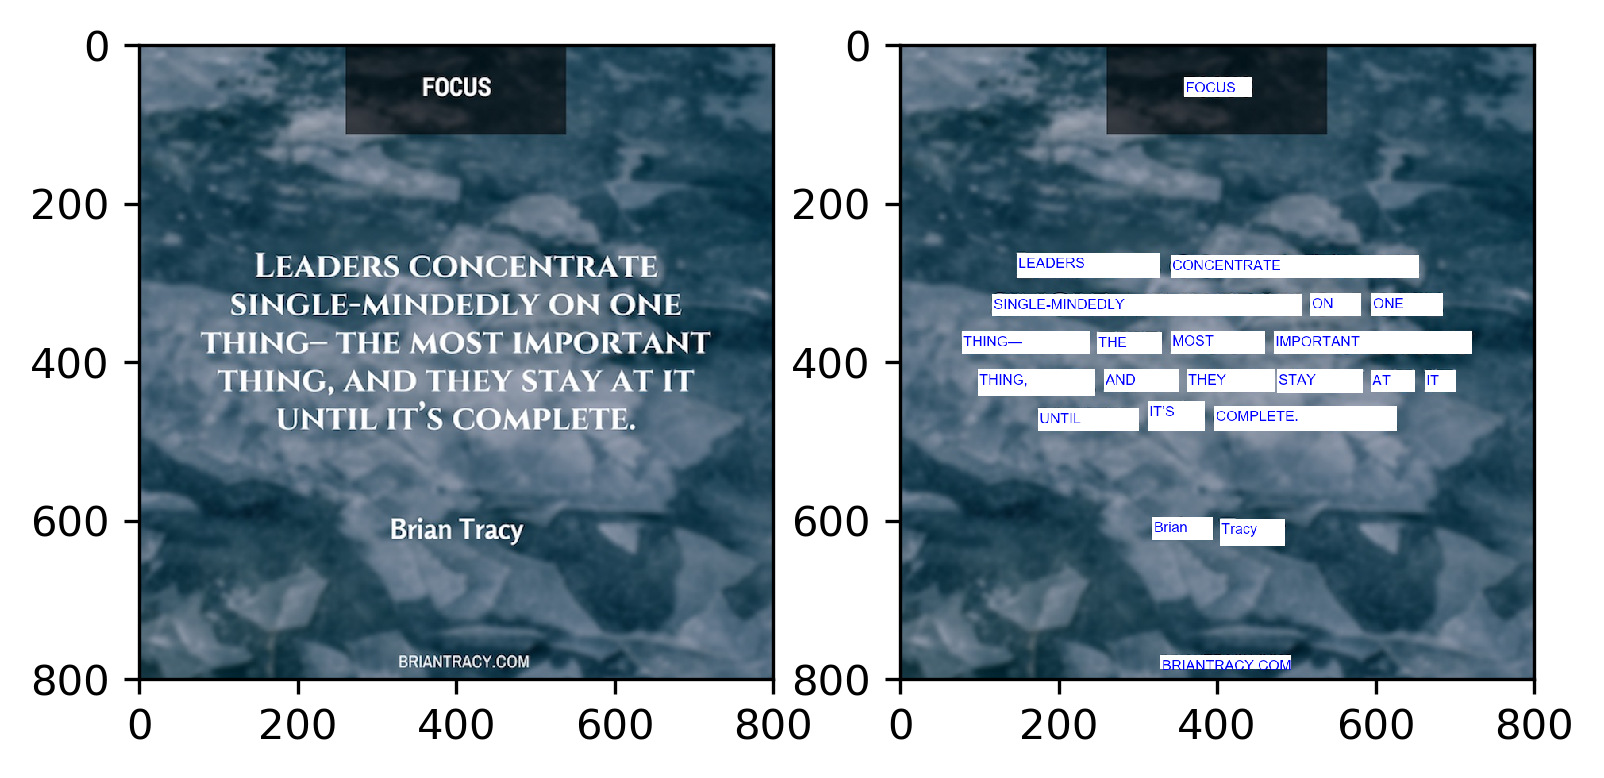

In [13]:
# display bounding boxes and recognized text with matplot&numpy
plt.rcParams['figure.dpi'] = 300  # dpi of displayed plot
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(np.asarray(im))
f.add_subplot(1, 2, 2)
plt.imshow(np.asarray(result_img))
plt.show(block=True)

In [14]:
# Delete api and pix
if api:
    tesseract.TessBaseAPIEnd(api)
    tesseract.TessBaseAPIDelete(api)

result = ffi.new('PIX**')
result[0] = pix
leptonica.pixDestroy(result)
del pix
del result
api = None

In [15]:
# Store results to csv file
import csv

with open('result.csv', 'wt', encoding='utf-8', newline='\n') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(results)
csvFile.close()